In [2]:
# %% [markdown]
# # 📊 TRỰC QUAN HÓA MÔ HÌNH MACHINE LEARNING
# ## Phân tích dự đoán xu hướng cổ phiếu với LightGBM & XGBoost
# 
# **Mục đích:** Visualization toàn diện các kết quả từ Task 4
# 
# **Nội dung:**
# 1. Load dữ liệu và models
# 2. Performance metrics visualization
# 3. ROC curves & Precision-Recall curves
# 4. Confusion matrices
# 5. Feature importance analysis
# 6. SHAP explainability
# 7. Backtesting visualization
# 8. Prediction distribution analysis

# %%
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)
import lightgbm as lgb
import xgboost as xgb
import shap

# Cấu hình style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# %%
# Load dữ liệu
print("📥 Loading data and models...")
df = pd.read_csv('features_engineered.csv', parse_dates=['date'])
df = df.sort_values(['date', 'symbol']).reset_index(drop=True)

# Load models
lgb_model = joblib.load('models/lgb_final.pkl')
scaler = joblib.load('models/scaler.pkl')

# Load results
fold_metrics = pd.read_csv('results/fold_metrics.csv')
daily_backtest = pd.read_csv('results/daily_backtest.csv', parse_dates=['date'])
feature_importance = pd.read_csv('results/lgb_feature_importance.csv')

print(f"✅ Loaded {len(df)} rows, {df['symbol'].nunique()} symbols")
print(f"✅ Date range: {df['date'].min()} to {df['date'].max()}")

📥 Loading data and models...
✅ Loaded 4649 rows, 30 symbols
✅ Date range: 2021-03-19 00:00:00 to 2021-10-28 00:00:00


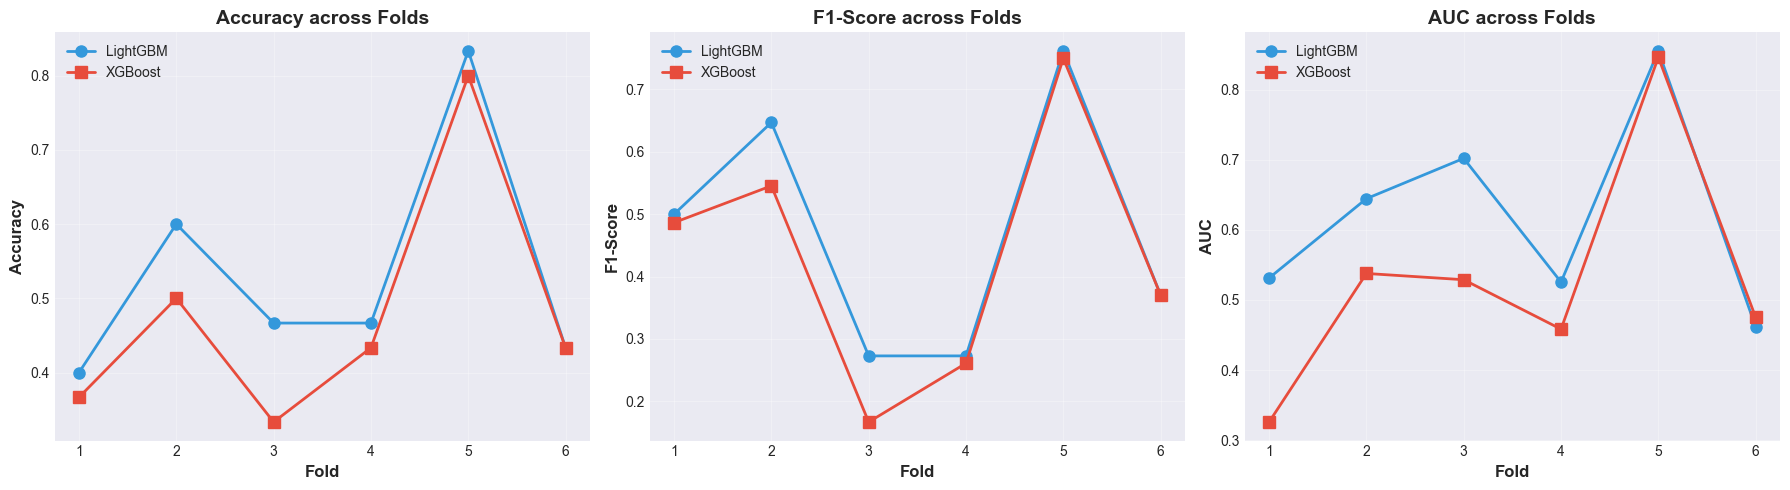


📊 SUMMARY METRICS:
      Model  Avg Accuracy  Avg F1  Avg AUC  Std Accuracy  Std F1  Std AUC
0  LightGBM        0.5333  0.4708   0.6200        0.1619  0.2026   0.1446
1   XGBoost        0.4778  0.4300   0.5287        0.1682  0.2100   0.1731


In [ ]:
# %% [markdown]
# ## 1. PERFORMANCE METRICS QUA CÁC FOLDS

# %%
# Plot metrics qua các folds
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['acc', 'f1', 'auc']
titles = ['Accuracy', 'F1-Score', 'AUC']
colors = ['#3498db', '#e74c3c']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx]
    
    lgb_vals = fold_metrics[f'lgb_{metric}'].values
    xgb_vals = fold_metrics[f'xgb_{metric}'].values
    folds = fold_metrics['fold'].values
    
    ax.plot(folds, lgb_vals, marker='o', linewidth=2, 
            markersize=8, label='LightGBM', color=colors[0])
    ax.plot(folds, xgb_vals, marker='s', linewidth=2, 
            markersize=8, label='XGBoost', color=colors[1])
    
    ax.set_xlabel('Fold', fontsize=12, fontweight='bold')
    ax.set_ylabel(title, fontsize=12, fontweight='bold')
    ax.set_title(f'{title} across Folds', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(folds)

plt.tight_layout()
plt.savefig('plots/metrics_across_folds.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Bảng tổng hợp metrics
print("\n📊 SUMMARY METRICS:")
summary_stats = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost'],
    'Avg Accuracy': [
        fold_metrics['lgb_acc'].mean(),
        fold_metrics['xgb_acc'].mean()
    ],
    'Avg F1': [
        fold_metrics['lgb_f1'].mean(),
        fold_metrics['xgb_f1'].mean()
    ],
    'Avg AUC': [
        fold_metrics['lgb_auc'].mean(),
        fold_metrics['xgb_auc'].mean()
    ],
    'Std Accuracy': [
        fold_metrics['lgb_acc'].std(),
        fold_metrics['xgb_acc'].std()
    ],
    'Std F1': [
        fold_metrics['lgb_f1'].std(),
        fold_metrics['xgb_f1'].std()
    ],
    'Std AUC': [
        fold_metrics['lgb_auc'].std(),
        fold_metrics['xgb_auc'].std()
    ]
})
print(summary_stats.round(4))

⚠️ Computing predictions...


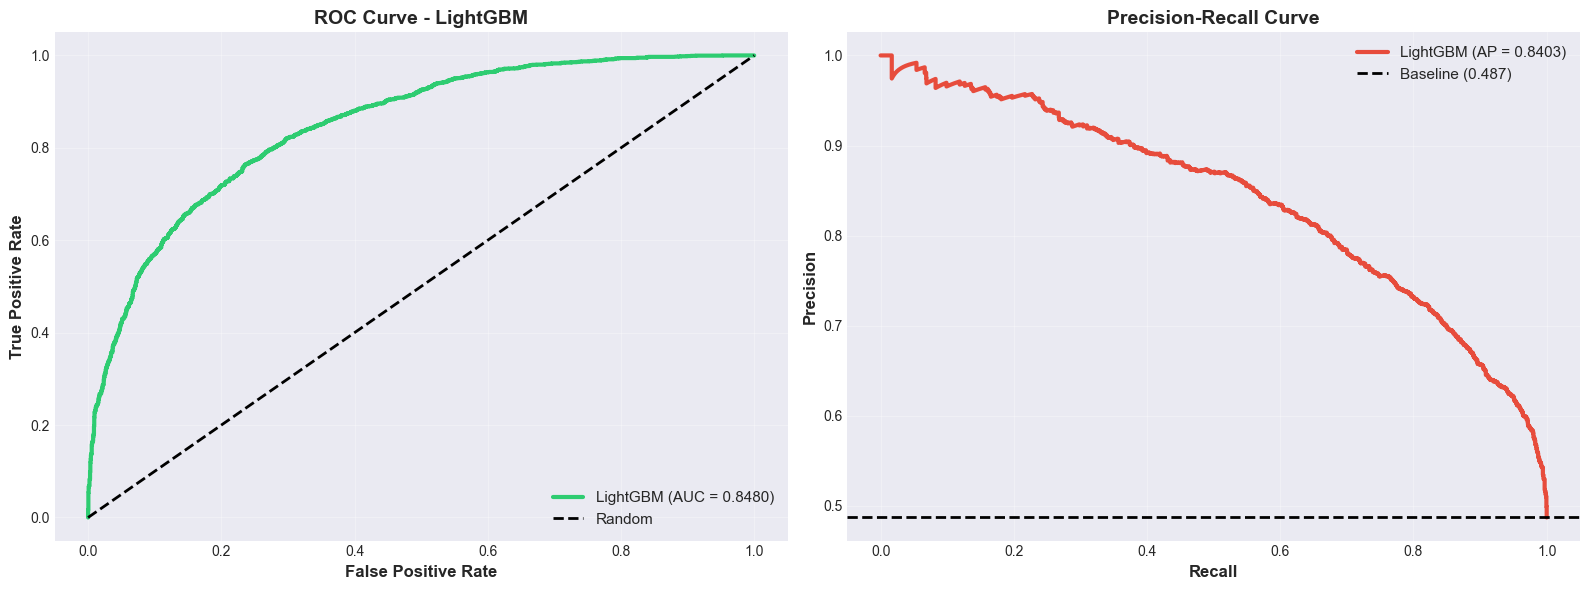

In [4]:
# %% [markdown]
# ## 2. 🎯 ROC CURVES & PRECISION-RECALL CURVES

# %%
# Load OOF predictions (from df if saved with probabilities)
# Nếu không có trong df, cần chạy lại prediction
if 'lgb_proba' not in df.columns:
    print("⚠️ Computing predictions...")
    exclude_cols = {"date", "symbol", "label_up_down", "target_return", 
                    "lgb_proba", "xgb_proba", "lgb_signal", "xgb_signal",
                    "next_ret", "lgb_pos", "lgb_pos_prev", "lgb_trade",
                    "xgb_pos", "xgb_pos_prev", "xgb_trade",
                    "lgb_strategy_ret", "xgb_strategy_ret"}
    feature_cols = [c for c in df.columns if c not in exclude_cols]
    X = df[feature_cols].values
    X_scaled = scaler.transform(X)
    df['lgb_proba'] = lgb_model.predict(X_scaled)

y_true = df['label_up_down'].values
y_proba_lgb = df['lgb_proba'].values

# %%
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_proba_lgb)
roc_auc = auc(fpr, tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC
ax1.plot(fpr, tpr, color='#2ecc71', linewidth=3, 
         label=f'LightGBM (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curve - LightGBM', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(True, alpha=0.3)

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_true, y_proba_lgb)
avg_precision = average_precision_score(y_true, y_proba_lgb)

ax2.plot(recall, precision, color='#e74c3c', linewidth=3,
         label=f'LightGBM (AP = {avg_precision:.4f})')
ax2.axhline(y=y_true.mean(), color='k', linestyle='--', linewidth=2,
            label=f'Baseline ({y_true.mean():.3f})')
ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

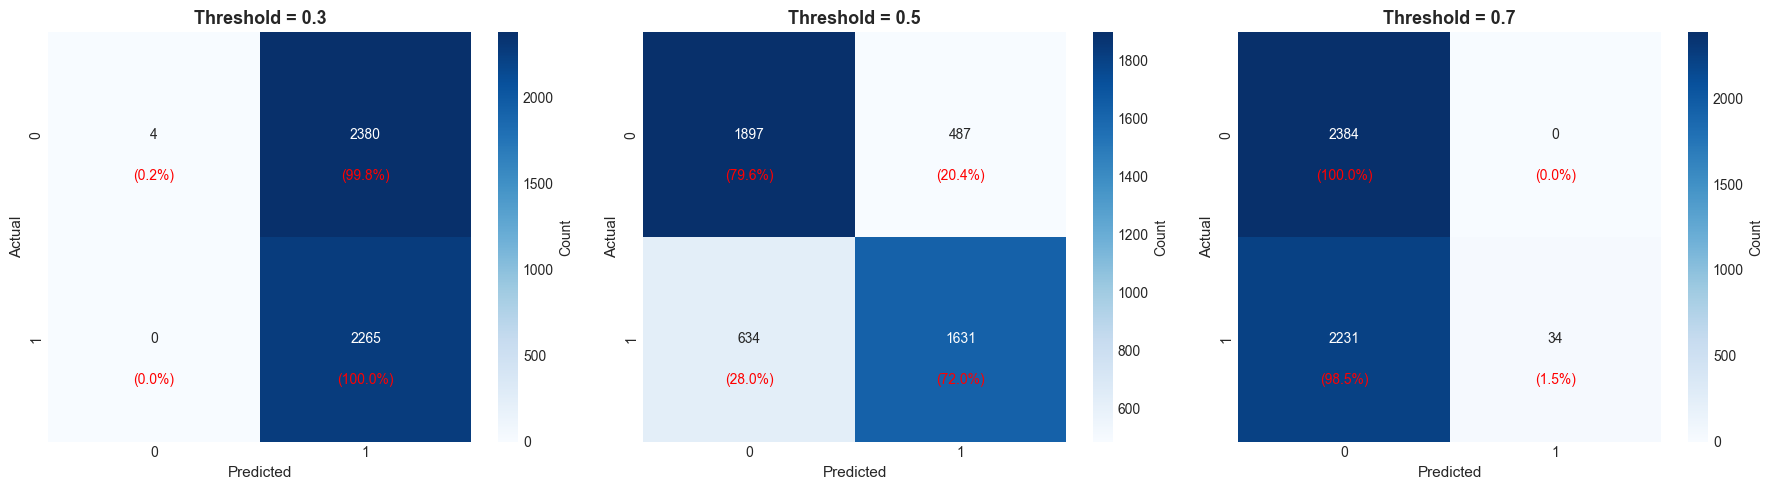

In [5]:
# %% [markdown]
# ## 3. 🔲 CONFUSION MATRIX ANALYSIS

# %%
# Confusion matrices với nhiều threshold khác nhau
thresholds_to_plot = [0.3, 0.5, 0.7]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, thr in enumerate(thresholds_to_plot):
    y_pred = (y_proba_lgb >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar_kws={'label': 'Count'})
    
    # Add percentages
    for i in range(2):
        for j in range(2):
            axes[idx].text(j+0.5, i+0.7, f'({cm_norm[i,j]:.1%})',
                          ha='center', va='center', fontsize=10, color='red')
    
    axes[idx].set_title(f'Threshold = {thr}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=11)
    axes[idx].set_ylabel('Actual', fontsize=11)

plt.tight_layout()
plt.savefig('plots/confusion_matrices_thresholds.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]

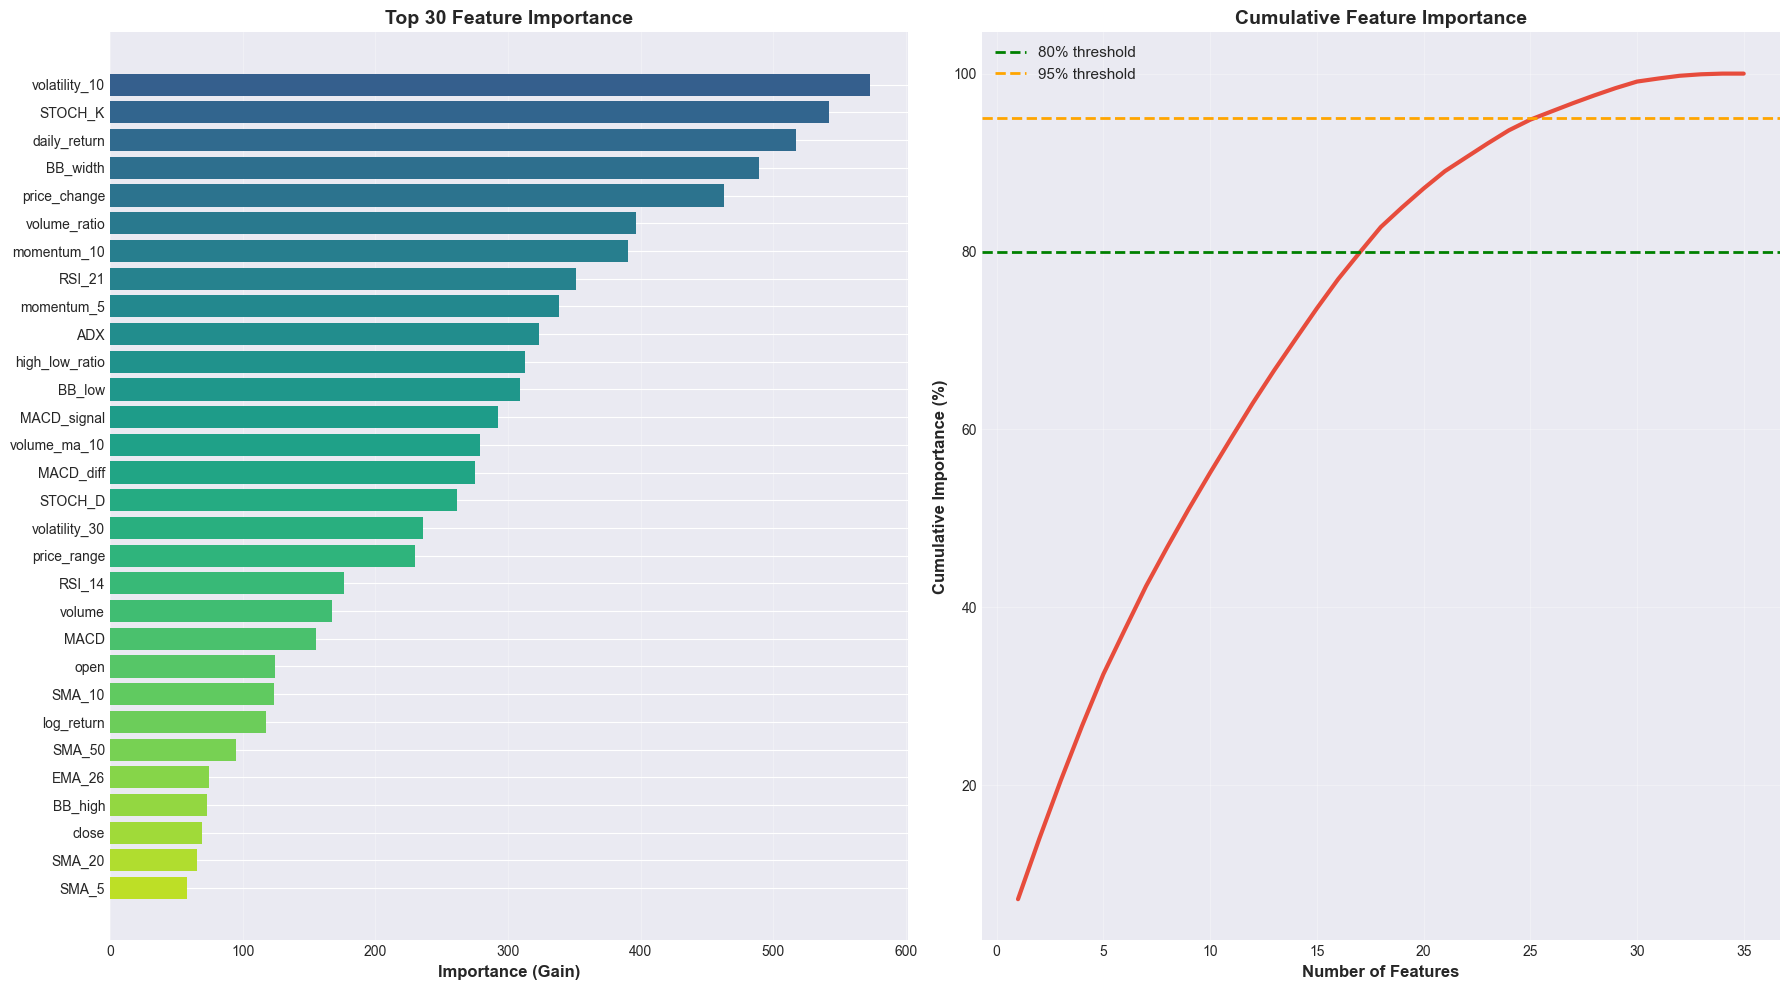


📊 FEATURE IMPORTANCE BY CATEGORY:


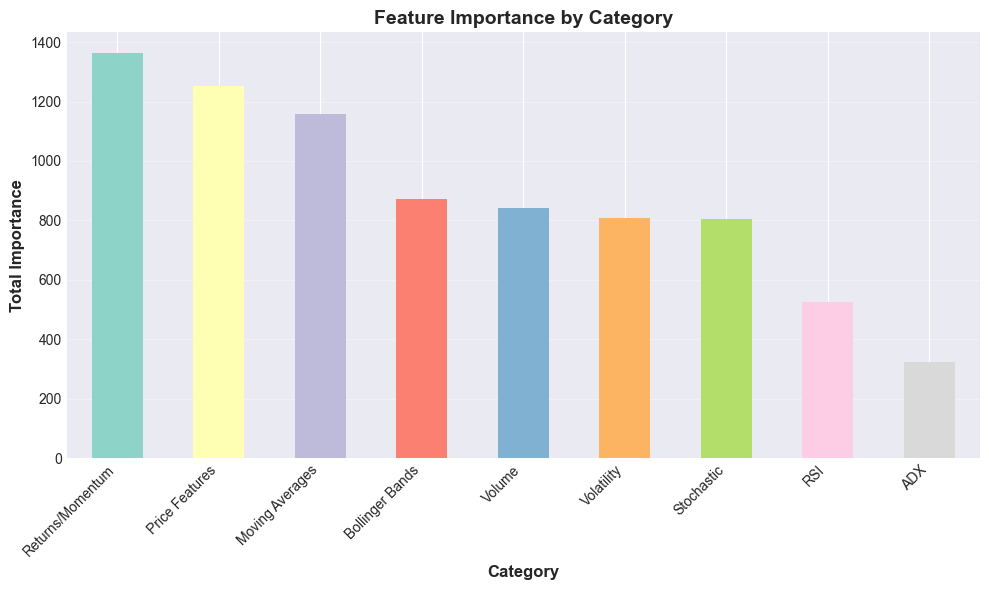

category
Returns/Momentum    1364.477567
Price Features      1251.820409
Moving Averages     1158.511292
Bollinger Bands      872.084860
Volume               842.261275
Volatility           808.876667
Stochastic           804.130570
RSI                  527.347480
ADX                  323.555529
Name: importance, dtype: float64


In [6]:
# %% [markdown]
# ## 4. 🎖️ FEATURE IMPORTANCE ANALYSIS

# %%
# Top 30 features
top_features = feature_importance.head(30)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# Horizontal bar chart
colors_grad = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
ax1.barh(range(len(top_features)), top_features['importance'].values[::-1], 
         color=colors_grad[::-1])
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'].values[::-1])
ax1.set_xlabel('Importance (Gain)', fontsize=12, fontweight='bold')
ax1.set_title('Top 30 Feature Importance', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Cumulative importance
top_features_sorted = feature_importance.sort_values('importance', ascending=False)
cumsum = top_features_sorted['importance'].cumsum()
cumsum_pct = cumsum / cumsum.iloc[-1] * 100

ax2.plot(range(1, len(cumsum_pct)+1), cumsum_pct.values, 
         linewidth=3, color='#e74c3c')
ax2.axhline(y=80, color='green', linestyle='--', linewidth=2, 
            label='80% threshold')
ax2.axhline(y=95, color='orange', linestyle='--', linewidth=2,
            label='95% threshold')
ax2.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/feature_importance_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Feature importance by category
print("\n📊 FEATURE IMPORTANCE BY CATEGORY:")

def categorize_feature(name):
    if 'SMA' in name or 'EMA' in name or 'MA' in name:
        return 'Moving Averages'
    elif 'RSI' in name:
        return 'RSI'
    elif 'MACD' in name:
        return 'MACD'
    elif 'BB' in name or 'bollinger' in name.lower():
        return 'Bollinger Bands'
    elif 'STOCH' in name:
        return 'Stochastic'
    elif 'ADX' in name:
        return 'ADX'
    elif 'volume' in name.lower():
        return 'Volume'
    elif 'return' in name.lower() or 'momentum' in name.lower():
        return 'Returns/Momentum'
    elif 'volatility' in name.lower():
        return 'Volatility'
    else:
        return 'Price Features'

feature_importance['category'] = feature_importance['feature'].apply(categorize_feature)
category_importance = feature_importance.groupby('category')['importance'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
category_importance.plot(kind='bar', ax=ax, color=plt.cm.Set3(range(len(category_importance))))
ax.set_title('Feature Importance by Category', fontsize=14, fontweight='bold')
ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Importance', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plots/feature_importance_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

print(category_importance)

🔍 Computing SHAP values (this may take a while)...


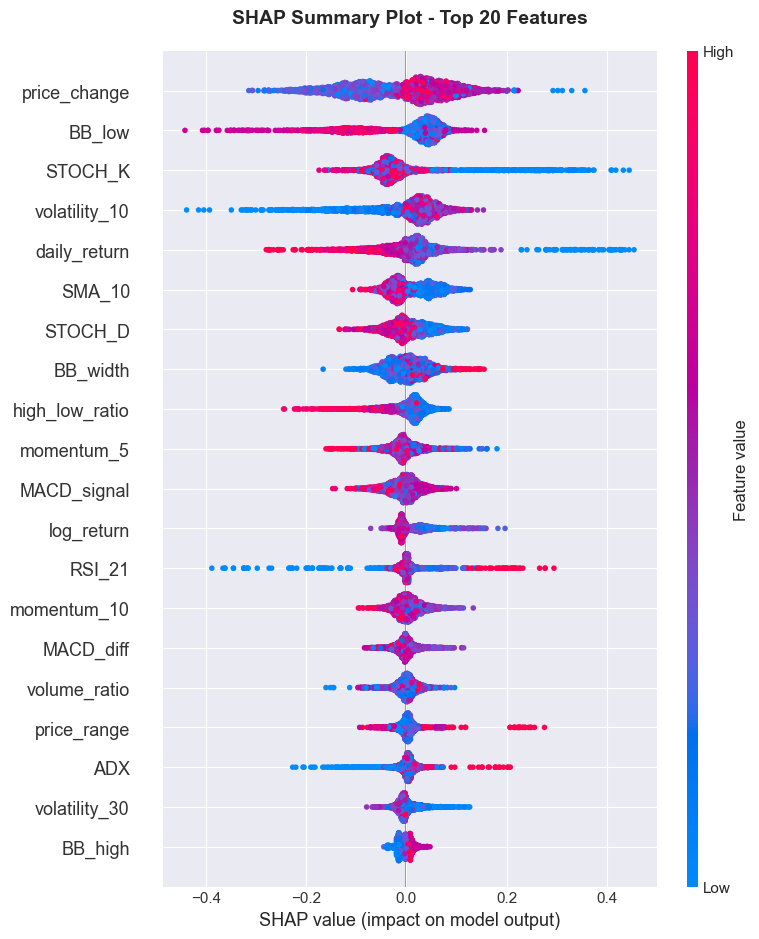

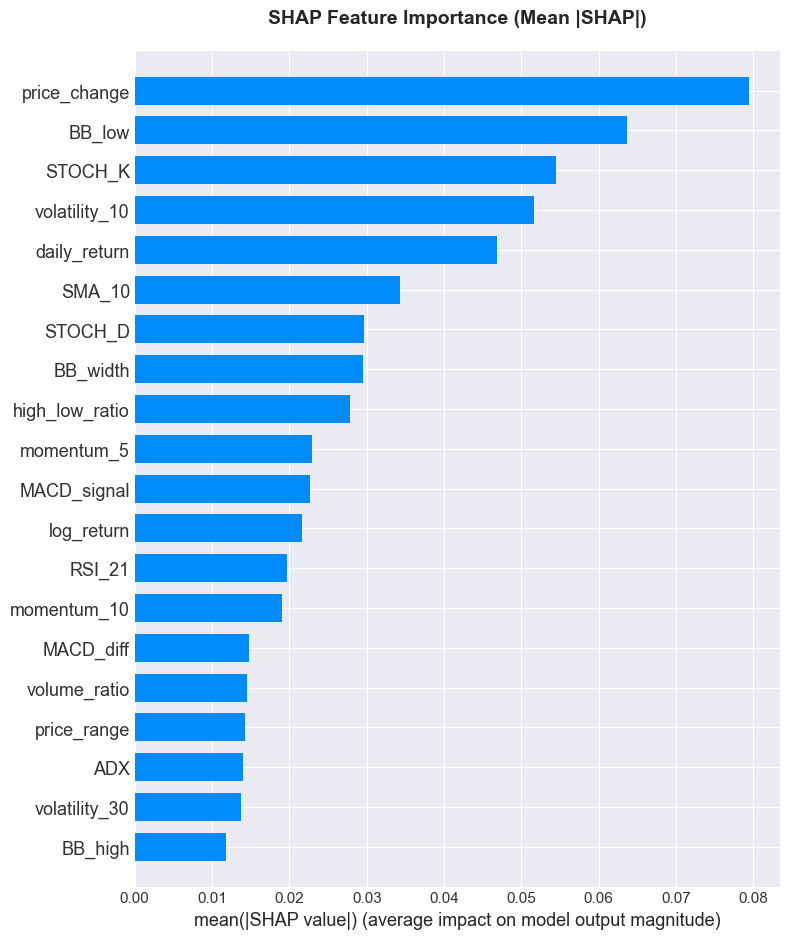

In [7]:
# %% [markdown]
# ## 5. 🔍 SHAP EXPLAINABILITY

# %%
# SHAP values visualization
print("🔍 Computing SHAP values (this may take a while)...")

# Sample data
sample_size = min(3000, len(df))
sample_idx = np.random.choice(len(df), sample_size, replace=False)

exclude_cols = {"date", "symbol", "label_up_down", "target_return",
                "lgb_proba", "xgb_proba", "lgb_signal", "xgb_signal",
                "next_ret", "lgb_pos", "lgb_pos_prev", "lgb_trade",
                "xgb_pos", "xgb_pos_prev", "xgb_trade",
                "lgb_strategy_ret", "xgb_strategy_ret"}
feature_cols = [c for c in df.columns if c not in exclude_cols]
X_sample = df[feature_cols].iloc[sample_idx]
X_sample_scaled = scaler.transform(X_sample)

# Compute SHAP
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_sample_scaled)

# Handle different output formats
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # For binary classification

# %%
# SHAP Summary Plot
fig = plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample_scaled, 
                  feature_names=feature_cols,
                  show=False, max_display=20)
plt.title('SHAP Summary Plot - Top 20 Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('plots/shap_summary_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# SHAP Bar Plot
fig = plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample_scaled,
                  feature_names=feature_cols,
                  plot_type='bar', show=False, max_display=20)
plt.title('SHAP Feature Importance (Mean |SHAP|)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('plots/shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()


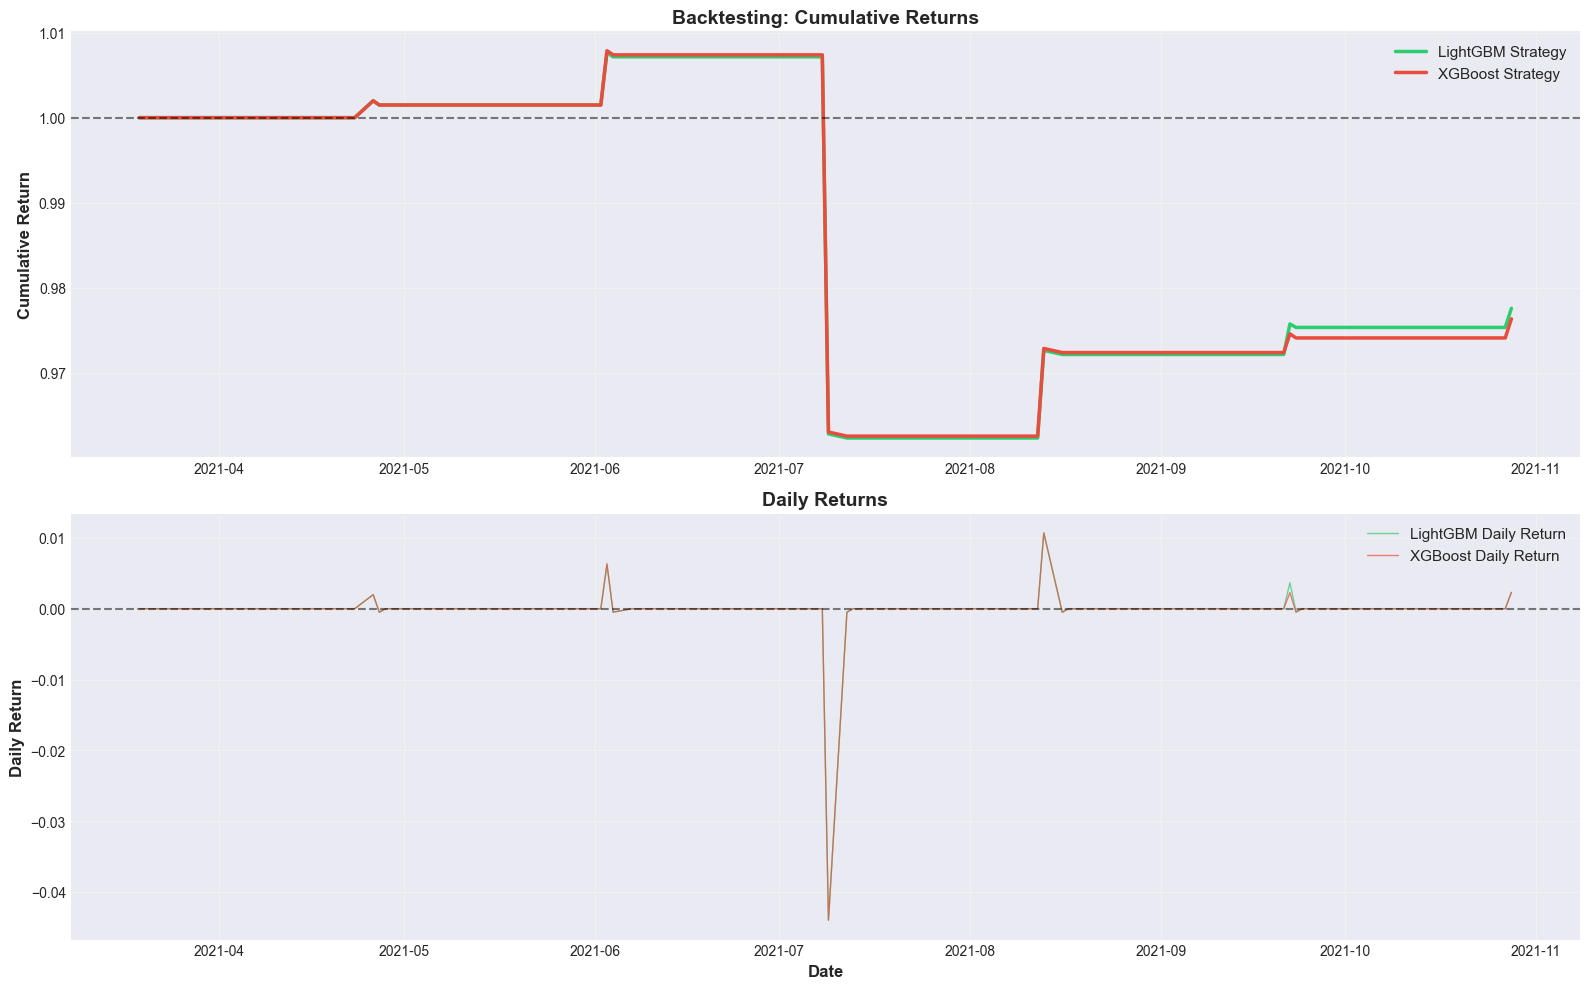

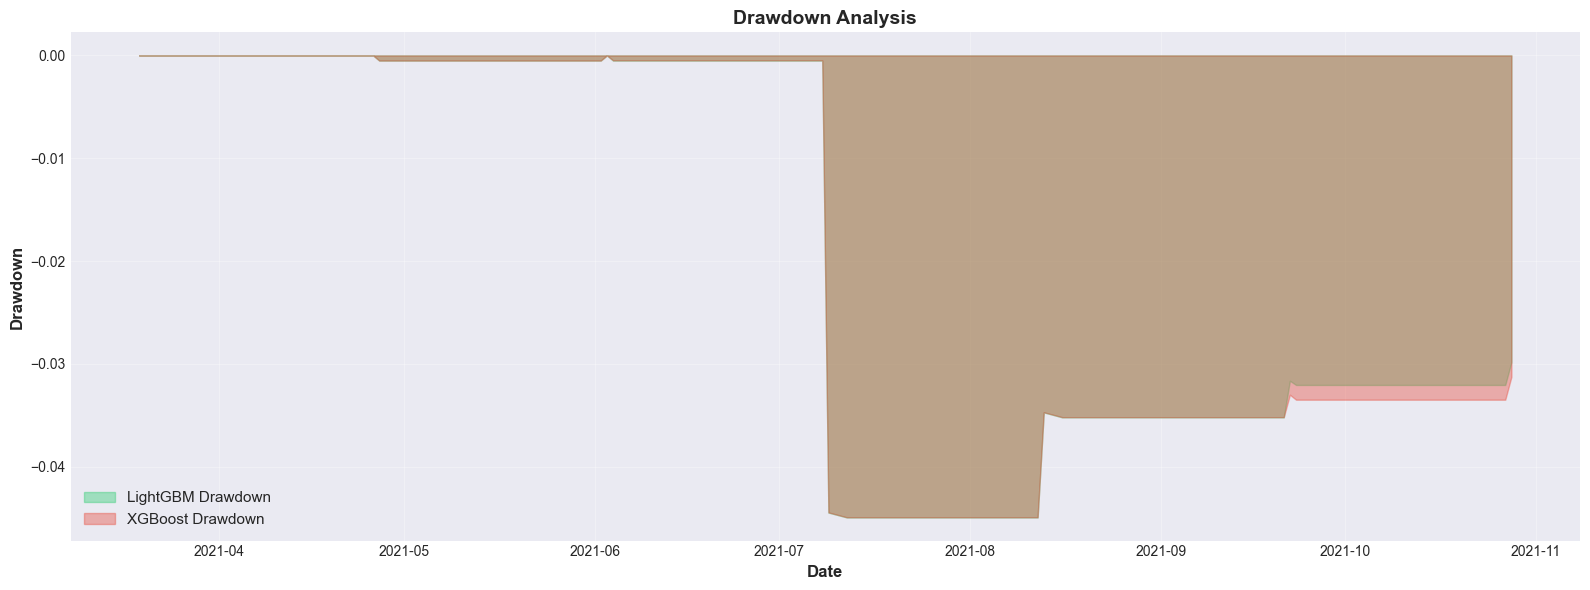


📉 Max Drawdown LGB: -4.49%
📉 Max Drawdown XGB: -4.49%


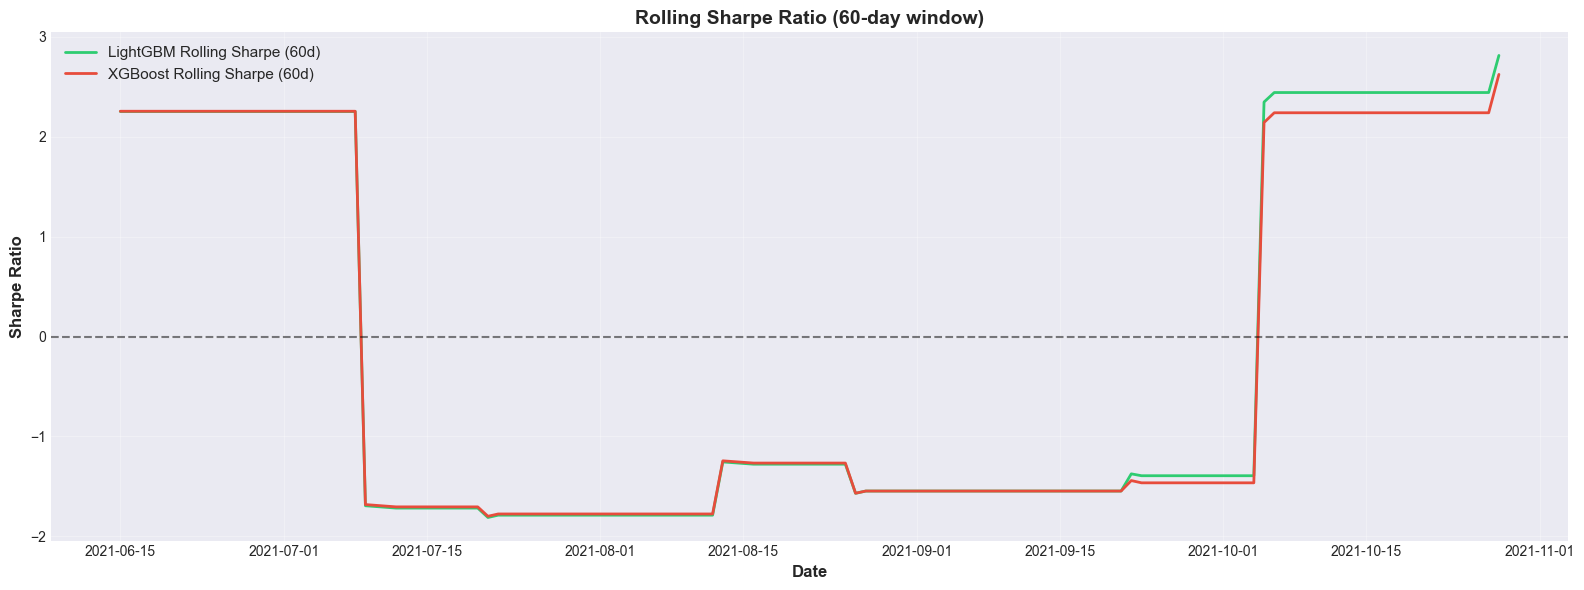

In [8]:
# %% [markdown]
# ## 6. 💰 BACKTESTING VISUALIZATION

# %%
# Cumulative returns
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Cumulative returns
ax1 = axes[0]
ax1.plot(daily_backtest['date'], daily_backtest['lgb_strat_ret_cum'], 
         linewidth=2.5, label='LightGBM Strategy', color='#2ecc71')
ax1.plot(daily_backtest['date'], daily_backtest['xgb_strat_ret_cum'],
         linewidth=2.5, label='XGBoost Strategy', color='#e74c3c')
ax1.axhline(y=1, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax1.set_ylabel('Cumulative Return', fontsize=12, fontweight='bold')
ax1.set_title('Backtesting: Cumulative Returns', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Daily returns
ax2 = axes[1]
ax2.plot(daily_backtest['date'], daily_backtest['lgb_strat_ret'], 
         linewidth=1, label='LightGBM Daily Return', color='#2ecc71', alpha=0.7)
ax2.plot(daily_backtest['date'], daily_backtest['xgb_strat_ret'],
         linewidth=1, label='XGBoost Daily Return', color='#e74c3c', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Daily Return', fontsize=12, fontweight='bold')
ax2.set_title('Daily Returns', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/backtest_returns.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Drawdown analysis
def compute_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown

dd_lgb = compute_drawdown(daily_backtest['lgb_strat_ret_cum'])
dd_xgb = compute_drawdown(daily_backtest['xgb_strat_ret_cum'])

fig, ax = plt.subplots(figsize=(16, 6))
ax.fill_between(daily_backtest['date'], dd_lgb, 0, 
                alpha=0.4, color='#2ecc71', label='LightGBM Drawdown')
ax.fill_between(daily_backtest['date'], dd_xgb, 0,
                alpha=0.4, color='#e74c3c', label='XGBoost Drawdown')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Drawdown', fontsize=12, fontweight='bold')
ax.set_title('Drawdown Analysis', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/drawdown_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📉 Max Drawdown LGB: {dd_lgb.min():.2%}")
print(f"📉 Max Drawdown XGB: {dd_xgb.min():.2%}")

# %%
# Sharpe ratio rolling
def rolling_sharpe(returns, window=60):
    return returns.rolling(window).mean() / returns.rolling(window).std() * np.sqrt(252)

sharpe_lgb = rolling_sharpe(daily_backtest['lgb_strat_ret'])
sharpe_xgb = rolling_sharpe(daily_backtest['xgb_strat_ret'])

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(daily_backtest['date'], sharpe_lgb, linewidth=2, 
        label='LightGBM Rolling Sharpe (60d)', color='#2ecc71')
ax.plot(daily_backtest['date'], sharpe_xgb, linewidth=2,
        label='XGBoost Rolling Sharpe (60d)', color='#e74c3c')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
ax.set_title('Rolling Sharpe Ratio (60-day window)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/rolling_sharpe.png', dpi=300, bbox_inches='tight')
plt.show()


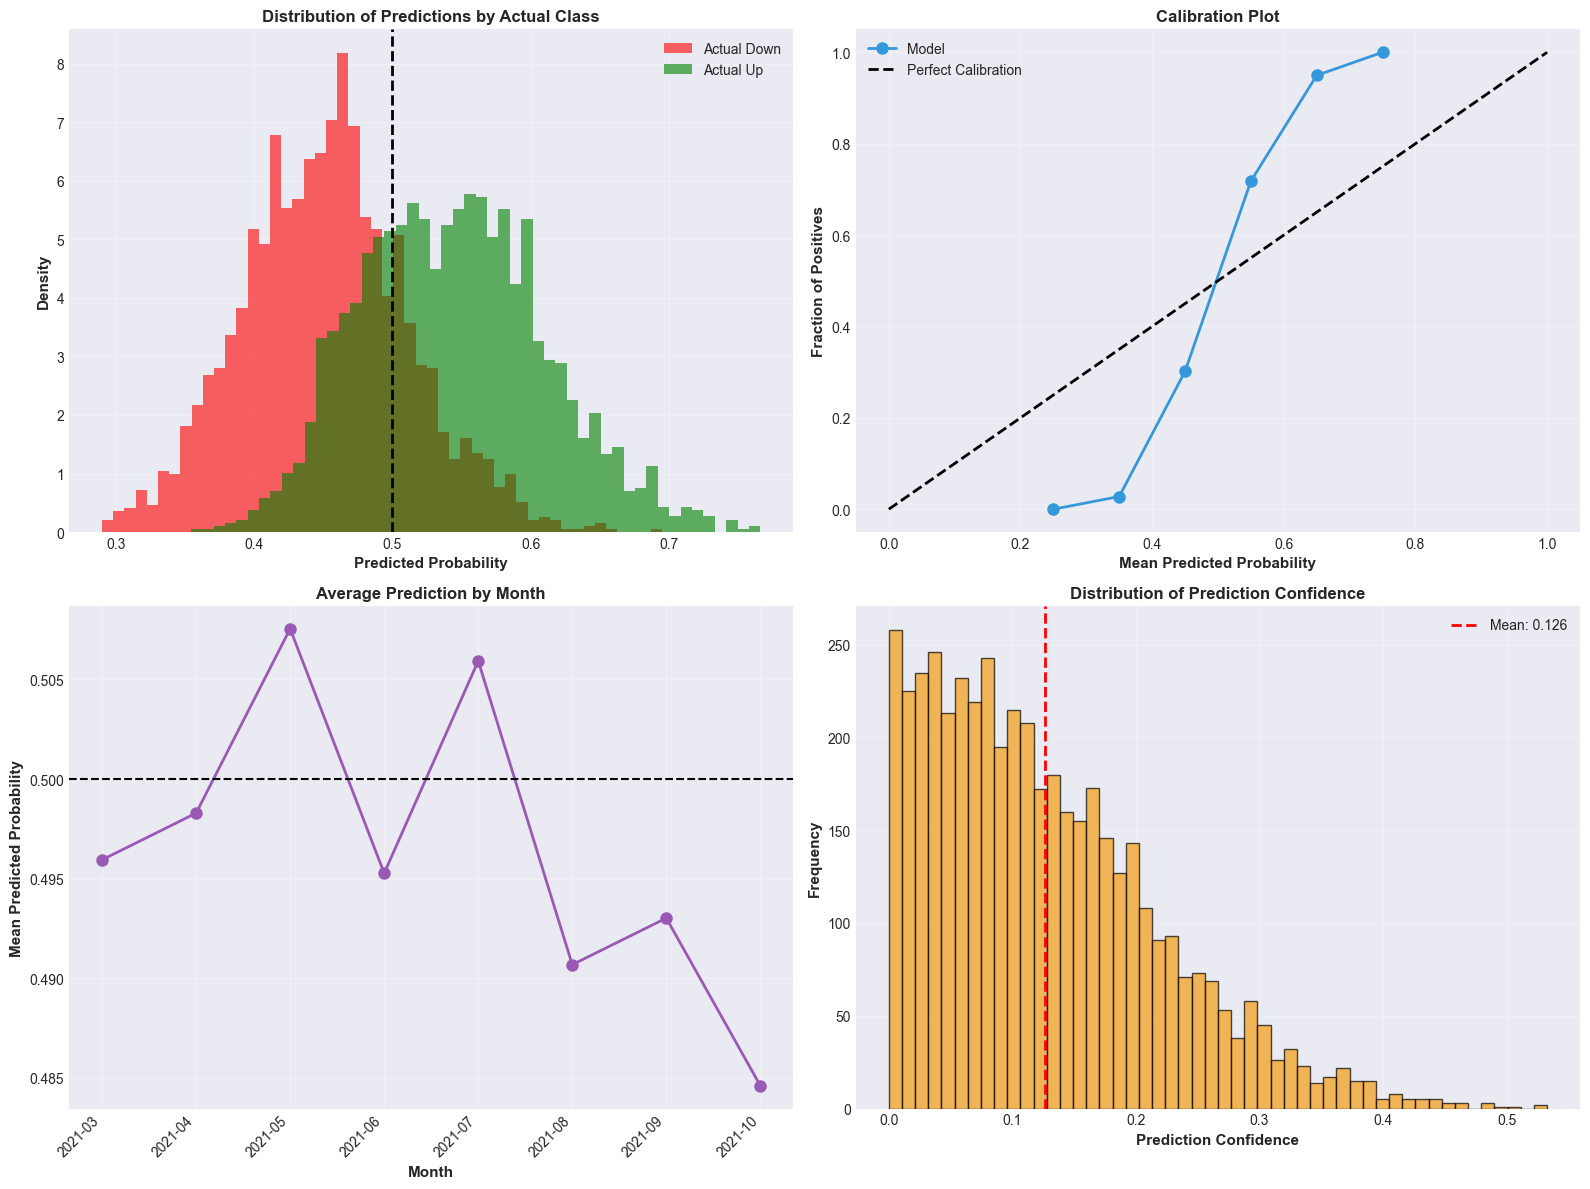

In [9]:
# %% [markdown]
# ## 7. 📊 PREDICTION DISTRIBUTION ANALYSIS

# %%
# Distribution of predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Histogram of probabilities
ax1 = axes[0, 0]
ax1.hist(y_proba_lgb[y_true == 0], bins=50, alpha=0.6, 
         label='Actual Down', color='red', density=True)
ax1.hist(y_proba_lgb[y_true == 1], bins=50, alpha=0.6,
         label='Actual Up', color='green', density=True)
ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=2)
ax1.set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
ax1.set_ylabel('Density', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Predictions by Actual Class', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Calibration plot
ax2 = axes[0, 1]
n_bins = 10
prob_true, prob_pred = [], []
for i in range(n_bins):
    lower = i / n_bins
    upper = (i + 1) / n_bins
    mask = (y_proba_lgb >= lower) & (y_proba_lgb < upper)
    if mask.sum() > 0:
        prob_pred.append((lower + upper) / 2)
        prob_true.append(y_true[mask].mean())

ax2.plot(prob_pred, prob_true, marker='o', linewidth=2, markersize=8,
         color='#3498db', label='Model')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
ax2.set_xlabel('Mean Predicted Probability', fontsize=11, fontweight='bold')
ax2.set_ylabel('Fraction of Positives', fontsize=11, fontweight='bold')
ax2.set_title('Calibration Plot', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Prediction by time
ax3 = axes[1, 0]
df_plot = df.copy()
df_plot['month'] = df_plot['date'].dt.to_period('M')
monthly_pred = df_plot.groupby('month')['lgb_proba'].mean()
ax3.plot(monthly_pred.index.astype(str), monthly_pred.values, 
         marker='o', linewidth=2, markersize=8, color='#9b59b6')
ax3.axhline(y=0.5, color='black', linestyle='--', linewidth=1.5)
ax3.set_xlabel('Month', fontsize=11, fontweight='bold')
ax3.set_ylabel('Mean Predicted Probability', fontsize=11, fontweight='bold')
ax3.set_title('Average Prediction by Month', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 4: Prediction confidence distribution
ax4 = axes[1, 1]
confidence = np.abs(y_proba_lgb - 0.5) * 2  # 0 to 1, where 1 is most confident
ax4.hist(confidence, bins=50, color='#f39c12', alpha=0.7, edgecolor='black')
ax4.axvline(x=confidence.mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {confidence.mean():.3f}')
ax4.set_xlabel('Prediction Confidence', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Distribution of Prediction Confidence', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/prediction_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

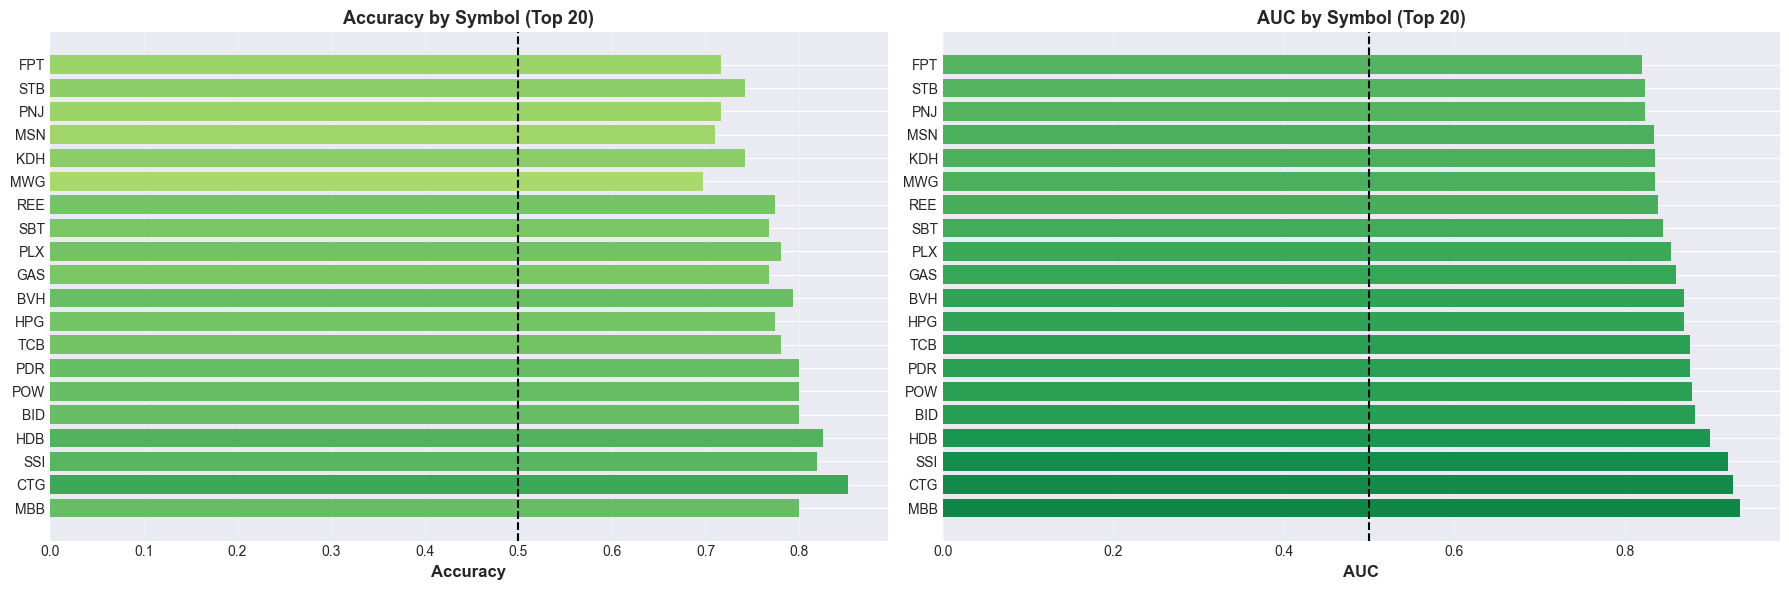


📊 TOP & BOTTOM PERFORMING SYMBOLS:

Top 5 by AUC:
   symbol  accuracy       auc  n_samples
8     MBB  0.800000  0.935231        155
2     CTG  0.851613  0.926559        155
17    SSI  0.819355  0.921513        155
5     HDB  0.825806  0.900266        155
0     BID  0.800000  0.882578        155

Bottom 5 by AUC:
   symbol  accuracy       auc  n_samples
7     KDH  0.741935  0.835007        155
9     MSN  0.709677  0.833779        155
13    PNJ  0.716129  0.823761        155
18    STB  0.741935  0.823461        155
3     FPT  0.716129  0.820346        155


In [10]:
# %% [markdown]
# ## 8. 📈 PER-SYMBOL PERFORMANCE

# %%
# Tính performance cho từng symbol
if 'symbol' in df.columns:
    symbol_performance = []
    
    for symbol in df['symbol'].unique()[:20]:  # Top 20 symbols
        symbol_data = df[df['symbol'] == symbol].copy()
        if len(symbol_data) < 10:
            continue
            
        y_sym = symbol_data['label_up_down'].values
        y_pred_sym = symbol_data['lgb_proba'].values
        
        from sklearn.metrics import accuracy_score, roc_auc_score
        
        acc = accuracy_score(y_sym, (y_pred_sym >= 0.5).astype(int))
        try:
            auc_score = roc_auc_score(y_sym, y_pred_sym)
        except:
            auc_score = np.nan
        
        symbol_performance.append({
            'symbol': symbol,
            'accuracy': acc,
            'auc': auc_score,
            'n_samples': len(symbol_data)
        })
    
    perf_df = pd.DataFrame(symbol_performance).dropna()
    perf_df = perf_df.sort_values('auc', ascending=False)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Accuracy by symbol
    ax1.barh(range(len(perf_df)), perf_df['accuracy'].values, 
             color=plt.cm.RdYlGn(perf_df['accuracy'].values))
    ax1.set_yticks(range(len(perf_df)))
    ax1.set_yticklabels(perf_df['symbol'].values)
    ax1.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Accuracy by Symbol (Top 20)', fontsize=13, fontweight='bold')
    ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=1.5)
    ax1.grid(axis='x', alpha=0.3)
    
    # AUC by symbol
    ax2.barh(range(len(perf_df)), perf_df['auc'].values,
             color=plt.cm.RdYlGn(perf_df['auc'].values))
    ax2.set_yticks(range(len(perf_df)))
    ax2.set_yticklabels(perf_df['symbol'].values)
    ax2.set_xlabel('AUC', fontsize=12, fontweight='bold')
    ax2.set_title('AUC by Symbol (Top 20)', fontsize=13, fontweight='bold')
    ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=1.5)
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/per_symbol_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n📊 TOP & BOTTOM PERFORMING SYMBOLS:")
    print("\nTop 5 by AUC:")
    print(perf_df.head()[['symbol', 'accuracy', 'auc', 'n_samples']])
    print("\nBottom 5 by AUC:")
    print(perf_df.tail()[['symbol', 'accuracy', 'auc', 'n_samples']])